<h1> Ideas to tune the network </h1>

**Problem**: The learning rate is not really smooth. While the trainings loss goes down the validation loss goes up again. Means the training / network is not optimal! 


In [1]:
# own library
import helperfile5 as hf
# generalls libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import uproot
from tensorflow.keras.optimizers import Adam
import datetime
import time
import keras.backend as k
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
# Current network: 

model = tf.keras.models.Sequential() 
layers = tf.keras.layers 
model.add(layers.Input(shape=(25,49,1)))
model.add(layers.Normalization(mean=0.107, variance=0.429))
model.add(layers.Conv2D(filters=8, kernel_size=(5, 5), activation='relu', input_shape=(25, 49, 1), padding="same"))
model.add(layers.AveragePooling2D(pool_size=(2,2), strides=2))
model.add(layers.Conv2D(filters=16, kernel_size=(4, 4), activation='relu', input_shape=(12, 24, 6), padding="same"))
model.add(layers.AveragePooling2D(pool_size=(2,2), strides=2))
model.add(layers.Flatten())
model.add(layers.Dense(units=256, activation = 'relu'))
model.add(layers.Dense(units=128, activation = 'relu'))
model.add(layers.Dense(units=64, activation = 'relu'))
model.add(layers.Dense(units=3, activation = 'softmax'))

model.summary()
model.compile(loss="categorical_crossentropy", optimizer=Adam(learning_rate=0.0001))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 25, 49, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 25, 49, 8)         208       
_________________________________________________________________
average_pooling2d (AveragePo (None, 12, 24, 8)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 24, 16)        2064      
_________________________________________________________________
average_pooling2d_1 (Average (None, 6, 12, 16)         0         
_________________________________________________________________
flatten (Flatten)            (None, 1152)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               2

I use 600 000 events, so the parameter size should be alright... 

But i could try: 
- [x] less params -> GOOD loss function! Performance not really better... 2 worse, 3 better.
- [x] max pooling instead of average pooling -> (2/3) worse, not really a significant improvement. 
- [x] play with learning rate (higher? lower?) -> higher: shape of loss better, but spiky! 3 besser gelernt, 2 bissi schlechter. lower: Sehr smoothe learning rate und Ausbalancierte Performance zwische 2 und 3. GUT!
- [x] increase parameters even more -> bad loss function, performance not really better.
- [x] use more data in generall (900 000)

Ok, this means: Use less parameter and increase learning rate a bit. Now let's train!
-> Well, one can clearly see overfitting.... Use Dropout!
- [x] Use dropout layers

Still a lot of overfitting...

<h1>Load the models </h1>
    show the plots as I didn't save them haha...
    

amought of data:
- 200 000 lessparams and parameterplay
- 300 000 all others

First evaluate networks with 200 000 clusters to not get confused haha. 

In [3]:
# load data

num_events = 200000

rootfile1 = uproot.open('./stage5_clusters_1gamma.root')
ipd1 = hf.InputData(rootfile1, 1, numevents=num_events)
ipd1.train_test_split()

rootfile2 = uproot.open('./stage5_clusters_2gamma.root')
ipd2 = hf.InputData(rootfile2, 2, numevents=num_events)
ipd2.train_test_split()

rootfile3 = uproot.open('./stage5_clusters_3gamma.root')
ipd3 = hf.InputData(rootfile3, 3, numevents=num_events)
ipd3.train_test_split()

# prep data
trainings_data = np.concatenate((ipd1.num_photons_t-1, ipd2.num_photons_t-1,  ipd3.num_photons_t-1))
training = hf.one_hot(trainings_data)
data_veri = np.concatenate((ipd1.num_photons_v-1, ipd2.num_photons_v-1, ipd3.num_photons_v-1))

clus = np.concatenate((ipd1.shash_t.reshape(len(ipd1.E_truth_train),25, 49, 1), ipd2.shash_t.reshape(len(ipd2.E_truth_train),25, 49, 1), ipd3.shash_t.reshape(len(ipd3.E_truth_train),25, 49, 1)))
clus_v = np.concatenate((ipd1.shash_v.reshape(len(ipd1.E_truth_veri),25, 49, 1), ipd2.shash_v.reshape(len(ipd2.E_truth_veri),25, 49, 1), ipd3.shash_v.reshape(len(ipd3.E_truth_veri),25, 49, 1)))


Loaded data
Formed cluster
Splitted data into training and test set!
Loaded data
Formed cluster
Splitted data into training and test set!
Loaded data
Formed cluster
Splitted data into training and test set!


In [4]:
model_lessparams = keras.models.load_model('./models/model_3photons_lessparams_2023-04-26')

model_paramplay1 = keras.models.load_model('./models/model_3photons_parameterplay_1_2023-04-28')

model_paramplay2 = keras.models.load_model('./models/model_3photons_parameterplay_2_2023-04-28')


<h2> Less params 

In [5]:
model_lessparams.summary()
output = model_lessparams.predict(clus_v)
ev = hf.Evaluation(output)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 25, 49, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 25, 49, 8)         208       
_________________________________________________________________
average_pooling2d (AveragePo (None, 12, 24, 8)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 24, 16)        2064      
_________________________________________________________________
average_pooling2d_1 (Average (None, 6, 12, 16)         0         
_________________________________________________________________
flatten (Flatten)            (None, 1152)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               2

[[0.980425 0.018125 0.00145 ]
 [0.030225 0.7826   0.187175]
 [0.00325  0.1621   0.83465 ]]


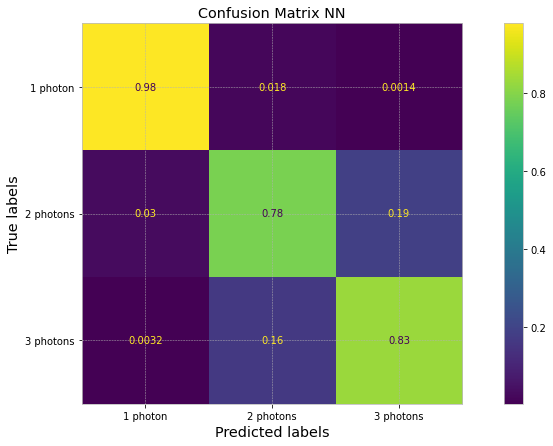

In [6]:
ev.show_confusion_matrix(data_veri, 3, save=True, title='3photons_lessparams')

<h2> Paramaterplay 1 

In [7]:
model_paramplay1.summary()
output = model_paramplay1.predict(clus_v)
ev = hf.Evaluation(output)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 25, 49, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 25, 49, 8)         296       
_________________________________________________________________
average_pooling2d (AveragePo (None, 12, 24, 8)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 24, 16)        2064      
_________________________________________________________________
average_pooling2d_1 (Average (None, 6, 12, 16)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 6, 12, 32)         4640      
_________________________________________________________________
average_pooling2d_2 (Average (None, 3, 6, 32)          0

[[9.99100e-01 8.50000e-04 5.00000e-05]
 [3.87250e-02 8.67225e-01 9.40500e-02]
 [5.15000e-03 2.10675e-01 7.84175e-01]]


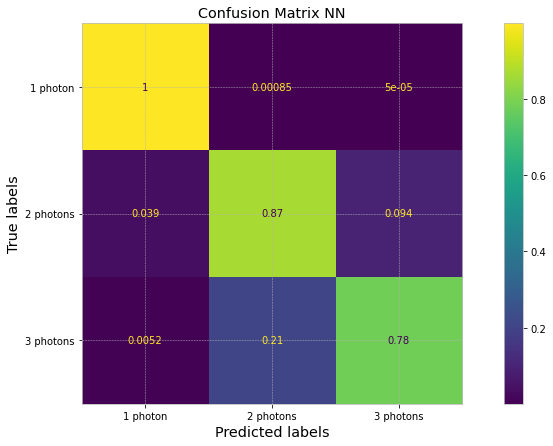

In [8]:
ev.show_confusion_matrix(data_veri, 3, save=True, title='3photons_paramplay1')

<h2> Paramaterplay 2 

In [9]:
model_paramplay2.summary()
output = model_paramplay2.predict(clus_v)
ev = hf.Evaluation(output)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_1 (Normalizati (None, 25, 49, 1)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 25, 49, 8)         136       
_________________________________________________________________
average_pooling2d_3 (Average (None, 12, 24, 8)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 12, 24, 16)        2064      
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 12, 24, 32)        4640      
_________________________________________________________________
average_pooling2d_4 (Average (None, 6, 12, 32)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2304)             

[[9.96700e-01 2.62500e-03 6.75000e-04]
 [3.50750e-02 7.96575e-01 1.68350e-01]
 [4.17500e-03 1.98575e-01 7.97250e-01]]


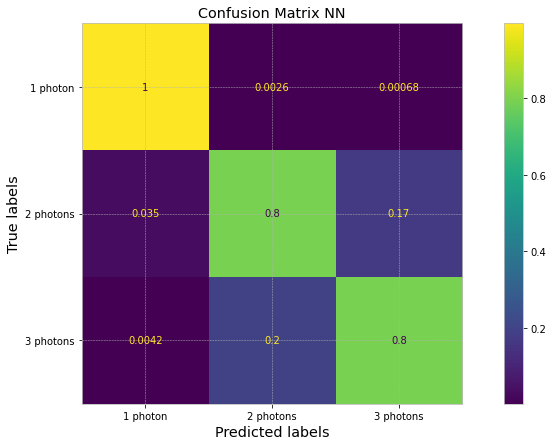

In [10]:
ev.show_confusion_matrix(data_veri, 3, save=True, title='3photons_paramplay2')

Now the networks with 300 000 cluster:

In [11]:
# load data

num_events = 300000

rootfile1 = uproot.open('./stage5_clusters_1gamma.root')
ipd1 = hf.InputData(rootfile1, 1, numevents=num_events)
ipd1.train_test_split()

rootfile2 = uproot.open('./stage5_clusters_2gamma.root')
ipd2 = hf.InputData(rootfile2, 2, numevents=num_events)
ipd2.train_test_split()

rootfile3 = uproot.open('./stage5_clusters_3gamma.root')
ipd3 = hf.InputData(rootfile3, 3, numevents=num_events)
ipd3.train_test_split()

# prep data
trainings_data = np.concatenate((ipd1.num_photons_t-1, ipd2.num_photons_t-1,  ipd3.num_photons_t-1))
training = hf.one_hot(trainings_data)
data_veri = np.concatenate((ipd1.num_photons_v-1, ipd2.num_photons_v-1, ipd3.num_photons_v-1))

clus = np.concatenate((ipd1.shash_t.reshape(len(ipd1.E_truth_train),25, 49, 1), ipd2.shash_t.reshape(len(ipd2.E_truth_train),25, 49, 1), ipd3.shash_t.reshape(len(ipd3.E_truth_train),25, 49, 1)))
clus_v = np.concatenate((ipd1.shash_v.reshape(len(ipd1.E_truth_veri),25, 49, 1), ipd2.shash_v.reshape(len(ipd2.E_truth_veri),25, 49, 1), ipd3.shash_v.reshape(len(ipd3.E_truth_veri),25, 49, 1)))


Loaded data
Formed cluster
Splitted data into training and test set!
Loaded data
Formed cluster
Splitted data into training and test set!
Loaded data
Formed cluster
Splitted data into training and test set!


In [13]:
model_alpha1 = keras.models.load_model('./models/model_3photons_alpha_1_2023-04-28')

model_alpha2 = keras.models.load_model('./models/model_3photons_alpha_2_2023-04-28')

model_alpha3 = keras.models.load_model('./models/model_3photons_alpha_3_2023-04-28')

model_maxpool = keras.models.load_model('./models/model_3photons_maxpool_2023-04-28')

model_tuned = keras.models.load_model('./models/model_3photons_tuned_2023-04-28')
model_tuned_D = keras.models.load_model('./models/model_3photons_tuned_dropout_2023-04-28')


<h2> alpha 1 - 0.001

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 25, 49, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 25, 49, 16)        416       
_________________________________________________________________
average_pooling2d (AveragePo (None, 12, 24, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 24, 32)        8224      
_________________________________________________________________
average_pooling2d_1 (Average (None, 6, 12, 32)         0         
_________________________________________________________________
flatten (Flatten)            (None, 2304)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               5

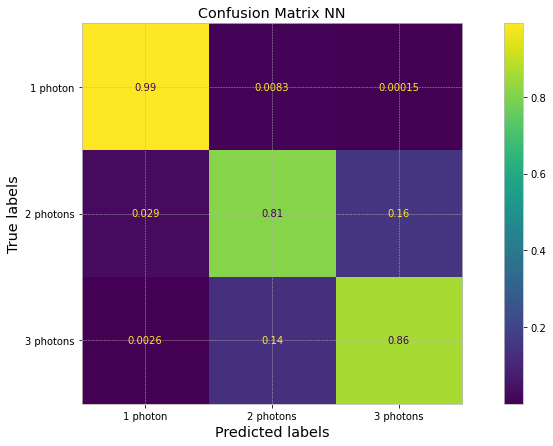

In [15]:
model_alpha1.summary()
output = model_alpha1.predict(clus_v)
ev = hf.Evaluation(output)
ev.show_confusion_matrix(data_veri, 3, save=True, title='3photons_alpha_1')

<h2> alpha 2 - 0.00001

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_1 (Normalizati (None, 25, 49, 1)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 25, 49, 16)        416       
_________________________________________________________________
average_pooling2d_2 (Average (None, 12, 24, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 24, 32)        8224      
_________________________________________________________________
average_pooling2d_3 (Average (None, 6, 12, 32)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 2304)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)              

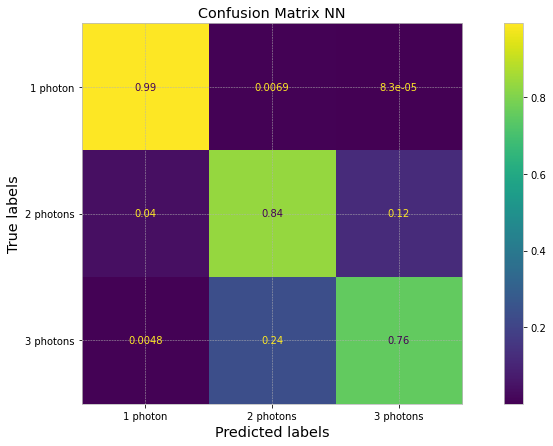

In [16]:
model_alpha2.summary()
output = model_alpha2.predict(clus_v)
ev = hf.Evaluation(output)
ev.show_confusion_matrix(data_veri, 3, save=True, title='3photons_alpha_2')

<h2> alpha 3 - 0.00001 same...?
 

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 25, 49, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 25, 49, 16)        416       
_________________________________________________________________
average_pooling2d (AveragePo (None, 12, 24, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 24, 32)        8224      
_________________________________________________________________
average_pooling2d_1 (Average (None, 6, 12, 32)         0         
_________________________________________________________________
flatten (Flatten)            (None, 2304)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               5

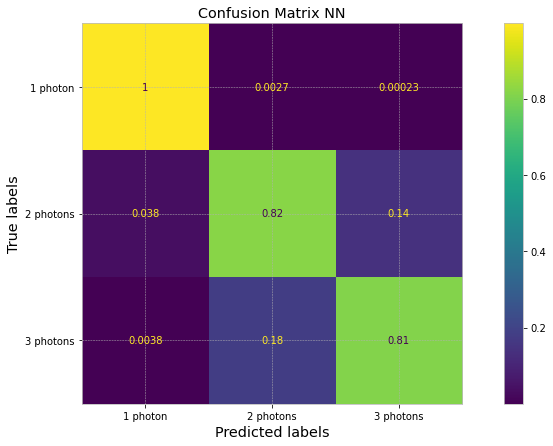

In [17]:
model_alpha3.summary()
output = model_alpha3.predict(clus_v)
ev = hf.Evaluation(output)
ev.show_confusion_matrix(data_veri, 3, save=True, title='3photons_alpha_3')

<h2> alpha 3 with dropout - 0.00001

 

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 25, 49, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 25, 49, 16)        416       
_________________________________________________________________
average_pooling2d (AveragePo (None, 12, 24, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 24, 32)        8224      
_________________________________________________________________
average_pooling2d_1 (Average (None, 6, 12, 32)         0         
_________________________________________________________________
flatten (Flatten)            (None, 2304)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               5

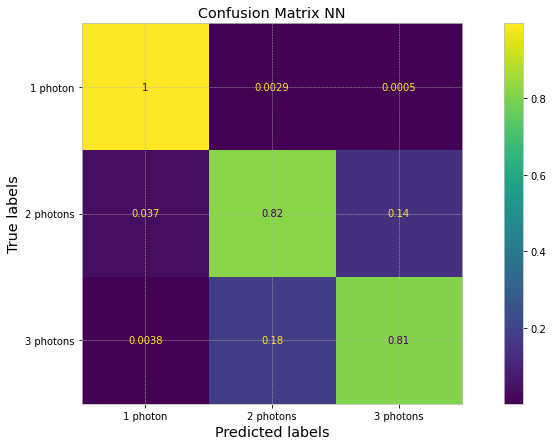

In [24]:

model_alpha3_D = keras.models.load_model('./models/model_3photons_alpha_3_withDropout_2023-05-01')
model_alpha3_D.summary()
output = model_alpha3_D.predict(clus_v)
ev = hf.Evaluation(output)
ev.show_confusion_matrix(data_veri, 3, save=True, title='3photons_alpha_3_withDropout')


<h2> Max pooling

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 25, 49, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 25, 49, 8)         208       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 24, 8)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 24, 16)        2064      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 12, 16)         0         
_________________________________________________________________
flatten (Flatten)            (None, 1152)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               2

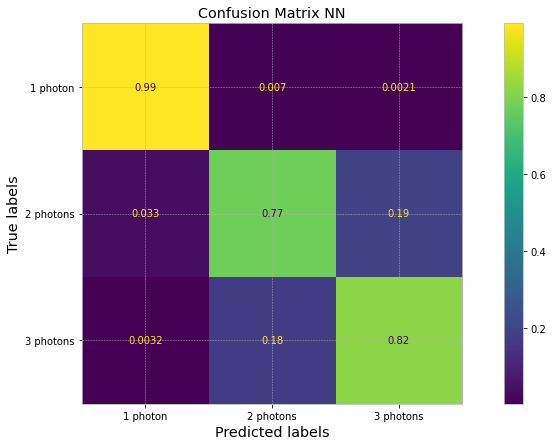

In [19]:
model_maxpool.summary()
output = model_maxpool.predict(clus_v)
ev = hf.Evaluation(output)
ev.show_confusion_matrix(data_veri, 3, save=True, title='3photons_maxpool')

<h2> Tuned

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 25, 49, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 25, 49, 8)         296       
_________________________________________________________________
average_pooling2d (AveragePo (None, 12, 24, 8)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 24, 16)        2064      
_________________________________________________________________
average_pooling2d_1 (Average (None, 6, 12, 16)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 6, 12, 32)         4640      
_________________________________________________________________
average_pooling2d_2 (Average (None, 3, 6, 32)          0

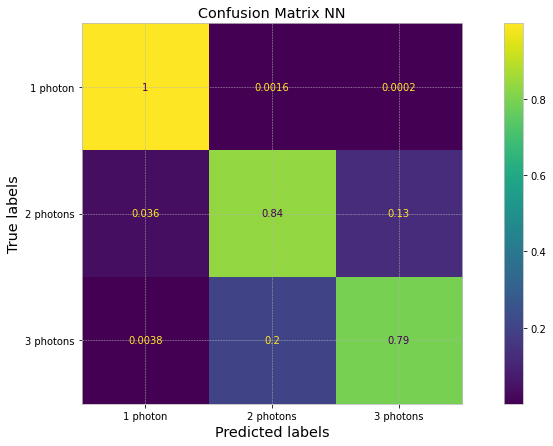

In [20]:
model_tuned.summary()
output = model_tuned.predict(clus_v)
ev = hf.Evaluation(output)
ev.show_confusion_matrix(data_veri, 3, save=True, title='3photons_tuned')

<h2> Tuned dropout

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 25, 49, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 25, 49, 8)         296       
_________________________________________________________________
average_pooling2d (AveragePo (None, 12, 24, 8)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 24, 16)        2064      
_________________________________________________________________
average_pooling2d_1 (Average (None, 6, 12, 16)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 6, 12, 32)         4640      
_________________________________________________________________
average_pooling2d_2 (Average (None, 3, 6, 32)          0

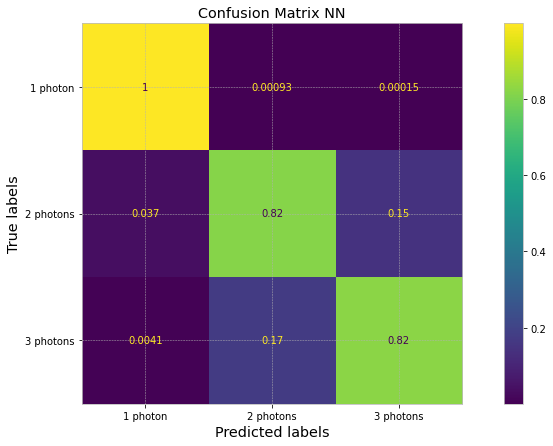

In [21]:
model_tuned_D.summary()
output = model_tuned_D.predict(clus_v)
ev = hf.Evaluation(output)
ev.show_confusion_matrix(data_veri, 3, save=True, title='3photons_tuned_dropout')